# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

sw = stopwords.words("english")

C:\Users\jessh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\jessh\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/jessh/Documents/ADS509/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




### Reading in Lyrics Data

In [3]:
# Read in the lyrics data
# getting the path to the lyrics folder
folder_path = data_location + lyrics_folder

# List to store all file paths
all_file_paths = []

# go through all directories and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        all_file_paths.append(file_path)
        
# read the contents of each file and store them along with the filename using the folder_paths variable
file_data = []
for file_path in all_file_paths:
    with open(file_path, 'r') as file:
        content = file.read()
        filename = os.path.relpath(file_path, folder_path) # Get the relative path as filename
        filename = os.path.basename(filename) # only getting the filename of whatever we pulled
        file_data.append((filename, content))

# create a dataframe with columns 'Filename' and 'File Content'
lyrics_df = pd.DataFrame(file_data, columns=['Filename', 'File Content'])

lyrics_df.head()

,Filename,File Content
0,dualipa_badtogether.txt,"""Bad Together"" lyrics\n\nDua Lipa Lyrics\n\n\n..."
1,dualipa_begging.txt,"""Begging"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""..."
2,dualipa_betheone.txt,"""Be The One"" lyrics\n\nDua Lipa Lyrics\n\n\n\n..."
3,dualipa_blowyourmindmwah.txt,"""Blow Your Mind (Mwah)"" lyrics\n\nDua Lipa Lyr..."
4,dualipa_dreams.txt,"""Dreams"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""D..."


### Reading in Twitter data

In [4]:
# Read in the twitter data
# change working directory
os.chdir(data_location+twitter_folder)

# define filepath for robyn
robyn_filepath = "robynkonichiwa_followers_data.txt"

# Read in the text file as a DataFrame
robyn_df = pd.read_csv(robyn_filepath, delimiter='\t') 
robyn_df.head(5)

,screen_name,name,id,location,followers_count,friends_count,description
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,I love chill •Facebook / Instagram / SoundClou...
1,songsfornikola,johnny,1502717352575651840,NaN,6,318,"books, movies, music, nature & TV shows. OG Sw..."
2,thibaud_lola,Thibaud Lola,1502407708246478852,NaN,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...
4,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...


In [5]:
# define filepath for cher
cher_filepath = "cher_followers_data.txt"

# define column names
columns = ["screen_name", "name", "id", "location", "followers_count", "friends_count", "description"]

# Initialize an empty list to store data
data = []

# Open the text file and read line by line
with open(cher_filepath, 'r', encoding = 'utf-8') as file:
    for line in file:
        # Split the line by tab delimiter
        fields = line.strip().split('\t')
        # If the line has expected number of fields
        if len(fields) == len(columns):
            data.append(fields)

# the list will be changed to a dataframe
cher_df = pd.DataFrame(data, columns=columns)

# dropping the first row
cher_df = cher_df.iloc[1:]
cher_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
cher_df.head(5)

,screen_name,name,id,location,followers_count,friends_count,description
0,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
1,anju79990584,anju,1496463006451974150,,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
2,gallionjenna,J,3366479914,,752,556,csu
3,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...
4,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,1386454132022824962,"Maine, USA",104,159,I’m unemployed and live with my parents. MOOPS!


In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# change directory
os.chdir(data_location)

# set up filepaths for the data
pos_filepath = "positive-words.txt"
neg_filepath = "negative-words.txt"
tidy_filepath = "tidytext_sentiments.txt"


# create function to read in the 3 files we need
def extract_words(file_path):
    # open and read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # filter out lines that start with a semicolon and non-empty lines
    words = [line.strip() for line in lines if not line.strip().startswith(';') and line.strip()]
    
    return words

# get words for each file
pos_words = extract_words(pos_filepath)
neg_words = extract_words(neg_filepath)

# create a DataFrame from the list of words
positive_df = pd.DataFrame(pos_words, columns=['word'])
positive_df['Score'] = 1
negative_df = pd.DataFrame(neg_words, columns = ['word'])
negative_df['Score'] = -1

# read in the text file as a DataFrame
tidy_df = pd.read_csv(tidy_filepath, delimiter='\t') 

# add a new column 'Score' with +1 for 'positive' and -1 for 'negative'
tidy_df['Score'] = tidy_df['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)
tidy_df = tidy_df.drop(['lexicon', 'sentiment'], axis = 1)

In [7]:
# combine all three dataframes together
pos_neg_df = pd.concat([positive_df, negative_df], ignore_index=True, axis = 0)
combined_df = pd.concat([pos_neg_df, tidy_df], ignore_index = True, axis = 0)

# Display the combined DataFrame
print("\nCombined DataFrame:")
print(combined_df)


Combined DataFrame:
            word  Score
0             a+      1
1         abound      1
2        abounds      1
3      abundance      1
4       abundant      1
...          ...    ...
21917        win      1
21918     winner      1
21919    winners      1
21920    winning      1
21921     worthy      1

[21922 rows x 2 columns]


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [8]:
# this function was taken from the textbook with a few tweaks

def sentiment_score(text, sentiment_df):
    # Convert DataFrame to dictionary for quick lookup
    word_dict = pd.Series(sentiment_df.Score.values, index=sentiment_df.word).to_dict()
    
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    
    if len(bag_of_words) == 0:  # Avoid division by zero
        return 0
    
    return sentiment_score / len(bag_of_words)

# clean and tokenize data
sw = set(stopwords.words("english")) 
punctuation = set(punctuation) # speeds up comparison

def clean_data(text):
    if isinstance(text, str):
        new_text = ''.join(char for char in text if char not in punctuation) # getting rid of punctuation
        
        # fold to lowercase and split on whitespace
        tokens = new_text.lower().split()
        
        # remove stopwords
        cleaned_tokens = [token for token in tokens if token not in sw]
        
        return cleaned_tokens
    else:
        return(text)



In [9]:
# clean and tokenize
clean_lyrics_df = lyrics_df['File Content'].apply(clean_data)

In [10]:
clean_lyrics_df = clean_lyrics_df.apply(lambda x: ' '.join(x))
lyrics_df['clean lyrics'] = clean_lyrics_df

In [11]:
lyrics_df.head()

,Filename,File Content,clean lyrics
0,dualipa_badtogether.txt,"""Bad Together"" lyrics\n\nDua Lipa Lyrics\n\n\n...",bad together lyrics dua lipa lyrics bad togeth...
1,dualipa_begging.txt,"""Begging"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""...",begging lyrics dua lipa lyrics begging highs l...
2,dualipa_betheone.txt,"""Be The One"" lyrics\n\nDua Lipa Lyrics\n\n\n\n...",one lyrics dua lipa lyrics one see moon see mo...
3,dualipa_blowyourmindmwah.txt,"""Blow Your Mind (Mwah)"" lyrics\n\nDua Lipa Lyr...",blow mind mwah lyrics dua lipa lyrics blow min...
4,dualipa_dreams.txt,"""Dreams"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""D...",dreams lyrics dua lipa lyrics dreams last nigh...


In [12]:
# score the lyrics
# Apply sentiment_score function to 'Text' column
lyrics_df['Sentiment_Score'] = lyrics_df['clean lyrics'].apply(lambda x: sentiment_score(x, combined_df))

In [13]:
# splitting based on artist for lyrics
dualipa_lyrics_df = lyrics_df[lyrics_df['Filename'].str.contains('dualipa', case = False)].reset_index()
hozier_lyrics_df = lyrics_df[lyrics_df['Filename'].str.contains('hozier', case = False)].reset_index()

In [14]:
dualipa_lyrics_df['Sentiment_Score']

0    -0.074074
1    -0.106742
2     0.016575
3    -0.032389
4     0.195572
5     0.086705
6    -0.030769
7     0.207547
8     0.000000
9     0.022857
10   -0.089686
11    0.000000
12    0.112245
13    0.040462
14    0.100000
15    0.104317
16    0.094017
17    0.030488
18   -0.058201
19   -0.085714
Name: Sentiment_Score, dtype: float64

In [15]:
avg_dualipa_sentiment = dualipa_lyrics_df['Sentiment_Score'].mean()
avg_dualipa_sentiment

0.026660492164171164

In [16]:
avg_hozier_sentiment = hozier_lyrics_df['Sentiment_Score'].mean()
avg_hozier_sentiment

0.04888700072132879

In [17]:
sorted_dualipa = dualipa_lyrics_df.sort_values(by = 'Sentiment_Score')
sorted_dualipa = sorted_dualipa.reset_index(drop = True)
print(sorted_dualipa['clean lyrics'][0])
print(f"\n {sorted_dualipa.tail(1)['clean lyrics'].values[0]}")
print(f"\n {sorted_dualipa.tail(2)['clean lyrics'].values[0]}")

begging lyrics dua lipa lyrics begging highs lows dont keep company ive breathing drinking youre remedy say youre gonna hold head say youre gonna break fall say youre gonna stay forever baby want cause bones begging beg begging beg love lungs begging beg begging beg love swear im gonna hold head swear im gonna break fall swear gonna last forever baby want cause bones begging beg begging beg love losing mind dreaming ill find another kind love blood veins thought taste cant give look face running away cause bones begging beg begging beg love swear im gonna hold head swear im gonna break fall swear gonna last forever baby want cause bones begging beg begging beg love say youre gonna hold head say youre gonna break fall say youre gonna stay forever baby want swear im gonna hold head swear im gonna break fall swear gonna last forever baby want cause bones begging beg begging beg love lungs begging beg begging beg love

 golden slumbers acoustic lyrics dua lipa lyrics golden slumbers acoust

In [18]:
sorted_hozier = hozier_lyrics_df.sort_values(by = 'Sentiment_Score')
sorted_hozier = sorted_hozier.reset_index(drop = True)
print(sorted_hozier['clean lyrics'][0])
print(f"\n {sorted_hozier.tail(1)['clean lyrics'].values[0]}")
print(f"\n {sorted_hozier.tail(2)['clean lyrics'].values[0]}")

woods somewhere lyrics hozier lyrics woods somewhere head warm skin soaked called name til fever broke awoke moon still hung night black darkness hums raised legs weak prayed mind good awful noise filled air heard scream woods somewhere womans voice quickly ran trees empty hands fox shook afraid spoke word sound made bone exposed hind lame raised stone end pain caused wound large teeth saw new eyes watching creature lunged turned ran save life didnt deer chase flew forgot prayers joining clutched life wished kept dearest love im done yet many years know ill bear found something woods somewhere

 love never die lyrics hozier lyrics love never die youve done wrong long long time youve done never changed mind honey please try love honey please honey try love never die flowers flowers grow im laid rest honey pick blossom hold hold breast honey know thats love bursting loud inside love oh love love never die

 like real people lyrics hozier lyrics like real people thought dear however scary

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Hozier had the higher average sentiment per song with a score of 0.049.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For the lowest scoring song for Dua Lipa, the word "beg" was in there a lot which is considered a negative word. Overall, that song has a negative meaning. Then for the 2 positive scoring songs, there were more positive words like "love", "yeah", "home", "lullaby" and "dreams". It reflects the positive meaning of the song.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Hozier, the lowest scoring song had words like "darkness", "scream", "empty", "afraid", "pain" - leading to a negative sentiment to the overall song. His two positive scoring songs had words like "love", "flowers", "sweet", "kiss" - leading to a positive sentiment of the song.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

See below for distribution plots.

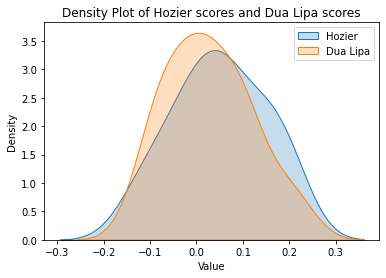

In [19]:
# Plotting using seaborn
hozier_scores = hozier_lyrics_df['Sentiment_Score'].to_numpy()
dua_scores = dualipa_lyrics_df['Sentiment_Score'].to_numpy()

sns.kdeplot(data = hozier_scores, label = 'Hozier', fill = True)
sns.kdeplot(data = dua_scores, label = 'Dua Lipa', fill = True)

# Labeling and Title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Hozier scores and Dua Lipa scores')

# Show Legend
plt.legend()

# Display plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [89]:
# create a function to extract emojis from text
def extract_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.findall(r':[a-zA-Z_0-9]+:', demojized_text)

# another one for a column in a dataframe
def extract_emojis_from_dataframe_column(df, column_name):
    emojis_list = []
    for value in df[column_name]:
        if isinstance(value, str):
            demojized_text = emoji.demojize(value)
            emojis = re.findall(r':[a-zA-Z_0-9]+:', demojized_text)
            emojis_list.extend(emojis)
    return emojis_list

# function to calculate sentiment score and track emoji occurrences
def calculate_sentiment_and_track_emojis(lists_to_compare, positive_emojis, negative_emojis):
    positive_score = 0
    negative_score = 0
    emoji_counts = defaultdict(int)  # Dictionary to store emoji counts
    
    for emoji_list in lists_to_compare:
        for emoji in emoji_list:
            if emoji in positive_emojis:
                positive_score += 1
                emoji_counts[emoji] += 1
            elif emoji in negative_emojis:
                negative_score += 1
                emoji_counts[emoji] += 1
    
    # overall sentiment score
    sentiment_score = positive_score - negative_score
    
    # sort emojis by their occurrence counts (most popular first)
    sorted_emojis = sorted(emoji_counts.items(), key=lambda x: x[1], reverse=True)
    
    return sentiment_score, sorted_emojis


def clean_data(text):
    if isinstance(text, str):
        new_text = ''.join(char for char in text if char not in punctuation) # getting rid of punctuation
        
        # fold to lowercase and split on whitespace
        tokens = new_text.lower().split()
        
        # remove stopwords
        cleaned_tokens = [token for token in tokens if token not in sw]
        
        return cleaned_tokens
    else:
        return(text)
    
# gotta make everything a str, not list
def list_to_str(cell):
    if isinstance(cell, float):
        return ''
    cell = [item for item in cell if not isinstance(item, float)] # filtering out float values
    return ''.join(map(str,cell))

# create a function to extract emojis from text
def extract_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.findall(r':[a-zA-Z_0-9]+:', demojized_text) # matching on regular expression to get the entirety of the emoji out


In [85]:
# define the emojis
positive_emojis = [':grinning_face_with_smiling_eyes:',':smiling_face_with_smiling_eyes:',':thumbs_up:',
                   ':smiling_face_with_sunglasses:',':glowing_star:',':party_popper:',':sun_with_face:',':clapping_hands:',
                  ':heart:, :heart_eyes']
negative_emojis = [':pensive_face:',
 ':disappointed_face:',
 ':crying_face:',
 ':enraged_face:',
 ':unamused_face:',
 ':loudly_crying_face:',
 ':broken_heart:',
 ':angry_face:',
 ':persevering_face:',
 ':slightly_frowning_face:']

In [65]:
# clean the description column
new_cher_df = cher_df['description'].apply(clean_data)
new_robyn_df = robyn_df['description'].apply(clean_data)

In [69]:
# only extract emojis
cher_emos = new_cher_df.apply(list_to_str)
new_cher_emos = cher_emos.apply(extract_emojis)
filtered_cher_emos = new_cher_emos[new_cher_emos.apply(lambda x: len(x) > 0)]

robyn_emos = new_robyn_df.apply(list_to_str)
new_robyn_emos = robyn_emos.apply(extract_emojis)
filtered_robyn_emos = new_robyn_emos[new_robyn_emos.apply(lambda x: len(x) > 0)]

In [94]:
# calculate sentiment scores
cher_score, cher_emojis = calculate_sentiment_and_track_emojis(filtered_cher_emos, positive_emojis, negative_emojis)
robyn_score, robyn_emojis = calculate_sentiment_and_track_emojis(filtered_robyn_emos, positive_emojis, negative_emojis)


In [96]:
# calculate average sentiment scores per follower
avg_cher_score = cher_score / cher_df.shape[0]
avg_robyn_score = robyn_score / robyn_df.shape[0]

In [97]:
# print results
print(f"Average sentiment score for cher: {avg_cher_score}")
print(f"Average sentiment score for robyn: {avg_robyn_score}")

Average sentiment score for cher: 0.008025626033811573
Average sentiment score for robyn: 0.0024897751528397934


In [98]:
cher_emojis

[(':smiling_face_with_sunglasses:', 5443),
 (':smiling_face_with_smiling_eyes:', 4761),
 (':sun_with_face:', 2928),
 (':glowing_star:', 2818),
 (':broken_heart:', 1588),
 (':thumbs_up:', 1573),
 (':party_popper:', 1075),
 (':grinning_face_with_smiling_eyes:', 796),
 (':loudly_crying_face:', 714),
 (':clapping_hands:', 611),
 (':pensive_face:', 382),
 (':crying_face:', 335),
 (':enraged_face:', 313),
 (':unamused_face:', 284),
 (':angry_face:', 115),
 (':disappointed_face:', 106),
 (':persevering_face:', 65),
 (':slightly_frowning_face:', 43)]

In [99]:
robyn_emojis

[(':smiling_face_with_sunglasses:', 276),
 (':smiling_face_with_smiling_eyes:', 184),
 (':glowing_star:', 173),
 (':sun_with_face:', 160),
 (':thumbs_up:', 99),
 (':party_popper:', 73),
 (':broken_heart:', 59),
 (':loudly_crying_face:', 41),
 (':grinning_face_with_smiling_eyes:', 35),
 (':clapping_hands:', 33),
 (':unamused_face:', 14),
 (':enraged_face:', 12),
 (':pensive_face:', 11),
 (':crying_face:', 9),
 (':angry_face:', 6),
 (':persevering_face:', 3),
 (':disappointed_face:', 1),
 (':slightly_frowning_face:', 1)]

Q: What is the average sentiment of your two artists? 

A: The average sentiment for cher was 0.008 and the average sentiment for robyn was 0.002. While the sentiment is positive, the reason i think the number is so small is because of the positive and negative emoji list that I chose. That list is way smaller than the number of followers each artist has.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For Cher,the most popular positive emoji was :smiling_face_with_sunglasses: and the most negative one was :broken_heart:. For robyn, the most popular positive emoji was also :smiling_face_with_sunglasses: and the most negative one was also :broken_heart:. 

